## Word2Vec

In [4]:
import numpy as np
import os
import nltk

import torch
import torch.nn
import torchtext.vocab as vocab
from sklearn import metrics
import pandas as pd
import warnings
from collections import Counter
from imblearn.over_sampling import RandomOverSampler, SMOTE  
from sklearn.metrics import accuracy_score, f1_score, recall_score
from sklearn.linear_model import LinearRegression
from datetime import datetime
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

warnings.filterwarnings("ignore")

## Function definition

In [6]:
def load_data():
    column = ['ProductName', 'level_1']
    df = pd.read_csv("D:/jupyter-workplace/classification_project/data_cleaning/unique_product_ros.csv", encoding='utf_8_sig', usecols=column)
    # print(df.columns)
    #df.drop(df[df.cat== 'Seafood'].index, inplace= True )
    df.columns = ['ProductName', 'level_1']
    texts = df['ProductName'].values
    df = df.fillna(-1)
    # labels = np.argmax(df[df.columns[-4:]].values, axis=1)
    labels = df['level_1'].values
    label2id = {l: i for i, l in enumerate(set(labels))}
    id2label = {i: l for l, i in label2id.items()}
    labels = [label2id[l] for l in labels]
    return texts, labels, id2label

In [7]:
def text_preprocess(text):
    text = str(text)
    english_punctuations = [',', '.', ':', ';', '?', '(', ')', '[', ']', '&', '!', '*', '@', '#', '$', '%', '\'', '/']
    text = "".join([(a if a not in english_punctuations else " ") for a in text])
    text = " ".join(nltk.tokenize.word_tokenize(text.lower()))
    return text

In [8]:
def load_embeddings():

    cache = '.vector_cache'
    if not os.path.exists(cache):
        os.mkdir(cache)

    word2vec = vocab.Vectors(name=r'./word2vec_300dim.txt', cache=cache)

    return word2vec

In [9]:
def encode_text_to_features(vector, text):
    vectors = vector.get_vecs_by_tokens(text.split())
    sentence_vector = torch.mean(vectors, dim=0)
    return sentence_vector.tolist()

In [10]:
def evaluation(predictions, labels, id2label, model_name=None):
    acc = accuracy_score(labels, predictions)
    recall = recall_score(labels, predictions, average="macro")
    f1 = f1_score(labels, predictions, average="macro")
    report = metrics.classification_report(labels, predictions,
                                           target_names=[id2label[i] for i in range(len(id2label))])
    info = "acc:%s, recall:%s, f1 score:%s" % (acc, recall, f1)
    if model_name is not None:
        info = "%s: %s" % (model_name, info)
    print(info)
    print(report)

## Read Data

In [11]:
col_list = ['ProductName', 'level_1']
data = pd.read_csv('D:/jupyter-workplace/classification_project/data_cleaning/unique_product_ros.csv', encoding='utf_8_sig', usecols=col_list)
data.columns = ['ProductName', 'level_1']
data.head()

,ProductName,level_1
0,Johnson's Baby Lotion,"Baby, Toddler & Kids"
1,Johnson's Baby Oil,"Baby, Toddler & Kids"
2,SMA Balanced Nutrition From Birth Infant Formula,"Baby, Toddler & Kids"
3,Johnson's Baby Powder,"Baby, Toddler & Kids"
4,Vaseline White Petroleum Jelly,"Baby, Toddler & Kids"


In [12]:
data = data.apply([text_preprocess])
data.columns = ['ProductName', 'level_1']
data.head()

,ProductName,level_1
0,johnson s baby lotion,baby toddler kids
1,johnson s baby oil,baby toddler kids
2,sma balanced nutrition from birth infant formula,baby toddler kids
3,johnson s baby powder,baby toddler kids
4,vaseline white petroleum jelly,baby toddler kids


## Prepare Word2Vec

In [13]:
corpus = open('./corpus.txt', 'w', encoding='utf_8_sig')
for i in range(len(data['ProductName'])):
    newline = data['ProductName'][i] + ' ' + data['level_1'][i] + '\n'
    corpus.write(newline)

In [14]:
from gensim.models import Word2Vec
from gensim.models.word2vec import LineSentence
import multiprocessing

In [15]:
readlines = open('./corpus.txt', 'r', encoding='utf_8_sig')

model = Word2Vec(LineSentence(readlines),
                 vector_size=300, window=5, min_count=10, sample=1e-5,
                 workers=multiprocessing.cpu_count(), epochs=5,)

model.wv.save_word2vec_format(r'./word2vec_300dim.txt', binary=False)

In [16]:
texts, labels, id2label = load_data()
texts = [text_preprocess(t) for t in texts]
vector = load_embeddings()
features = [encode_text_to_features(vector, text) for text in texts]
print("data len:", len(texts))
print("id2label",id2label)

data len: 41250
id2label {0: 'Beer, Cider & Wine', 1: 'Personal Care', 2: 'Drinks', 3: 'Featured', 4: 'Pets', 5: 'Meal Spot', 6: 'Pantry', 7: 'Baby, Toddler & Kids', 8: 'Chilled, Frozen & Desserts', 9: 'Fresh Foods & Bakery', 10: 'Kitchen, Dining & Household'}


In [17]:
#Start Training
x_train, x_test, y_train, y_test = train_test_split(features, labels, test_size=0.25,
                                                                            random_state=3)

## Logistic Rregression

In [18]:
# logistic
model = LinearRegression()
model.fit(x_train, y_train)
predict_labels = model.predict(x_test)
# print(predict_labels)
predict_labels = [np.round(p) for p in predict_labels]
max_label = len(id2label) - 1
predict_labels = [l if max_label >= l else max_label for l in predict_labels]
min_label = 0
predict_labels = [l if min_label <= l else min_label for l in predict_labels]
evaluation(predict_labels, y_test,id2label, "logistic")

logistic: acc:0.19567536119460874, recall:0.19554136311645118, f1 score:0.19041338917208508
                             precision    recall  f1-score   support

         Beer, Cider & Wine       0.71      0.22      0.34       929
              Personal Care       0.15      0.05      0.07       942
                     Drinks       0.28      0.21      0.24       953
                   Featured       0.19      0.23      0.21       930
                       Pets       0.17      0.30      0.22       933
                  Meal Spot       0.15      0.30      0.19       941
                     Pantry       0.12      0.23      0.16       949
       Baby, Toddler & Kids       0.23      0.32      0.27       931
 Chilled, Frozen & Desserts       0.20      0.14      0.17       951
       Fresh Foods & Bakery       0.36      0.10      0.16       943
Kitchen, Dining & Household       0.20      0.05      0.07       911

                   accuracy                           0.20     10313
         

## KNN 

In [19]:
# knn
k = len(id2label)
model = KNeighborsClassifier(n_neighbors=k)
model.fit(x_train, y_train)
predict_labels = model.predict(x_test)
evaluation(predict_labels, y_test, id2label, "knn")

knn: acc:0.9008048094637836, recall:0.9013587336385676, f1 score:0.8980955923337475
                             precision    recall  f1-score   support

         Beer, Cider & Wine       0.80      0.94      0.87       929
              Personal Care       0.94      0.83      0.88       942
                     Drinks       0.94      0.96      0.95       953
                   Featured       0.94      1.00      0.97       930
                       Pets       0.95      0.98      0.97       933
                  Meal Spot       0.93      0.98      0.96       941
                     Pantry       0.94      0.61      0.74       949
       Baby, Toddler & Kids       0.91      0.99      0.95       931
 Chilled, Frozen & Desserts       0.87      0.85      0.86       951
       Fresh Foods & Bakery       0.94      0.86      0.90       943
Kitchen, Dining & Household       0.79      0.91      0.85       911

                   accuracy                           0.90     10313
                 

## SVM

In [20]:
from sklearn.svm import SVC
from sklearn.multiclass import OneVsRestClassifier
model = OneVsRestClassifier(SVC())#C=1, gamma=20, decision_function_shape='ovr'))
model.fit(x_train, y_train)
predict_labels = model.predict(x_test)
evaluation(predict_labels, y_test, id2label, "svm")

svm: acc:0.9707165713177542, recall:0.9708160203613755, f1 score:0.9706545362533755
                             precision    recall  f1-score   support

         Beer, Cider & Wine       0.99      0.95      0.97       929
              Personal Care       0.97      0.97      0.97       942
                     Drinks       0.99      0.99      0.99       953
                   Featured       0.99      1.00      1.00       930
                       Pets       1.00      1.00      1.00       933
                  Meal Spot       0.98      0.98      0.98       941
                     Pantry       0.96      0.88      0.92       949
       Baby, Toddler & Kids       1.00      0.99      0.99       931
 Chilled, Frozen & Desserts       0.95      0.97      0.96       951
       Fresh Foods & Bakery       0.96      0.97      0.97       943
Kitchen, Dining & Household       0.90      0.97      0.94       911

                   accuracy                           0.97     10313
                 

## GDBT

In [21]:
# GDBT
import lightgbm as lgb

def lgb_model(x_train, x_test, y_train, y_test, verbose):
    params = {'num_leaves': 60,
    'min_data_in_leaf': 30,
    'objective': 'multiclass',
    'num_class': 33,
    'max_depth': -1,
    'learning_rate': 0.03,
    "min_sum_hessian_in_leaf": 6,
    "boosting": "gbdt",
    "feature_fraction": 0.9,
    "bagging_freq": 1,
    "bagging_fraction": 0.8,
    "bagging_seed": 11,
    "lambda_l1": 0.1,
    "verbosity": -1,
    "nthread": 15,
    'metric': 'multi_error',
    "random_state": 2020
          }

    model = lgb.train(params
                      , lgb.Dataset(x_train, y_train)
                      , num_boost_round = 100000
                      , valid_sets = [lgb.Dataset(x_test, y_test)]
                      , verbose_eval = verbose
                      , early_stopping_rounds = 500
                     )

    print('Predicting...')
    y_prob = model.predict(x_test, num_iteration=model.best_iteration)
    y_pred = [list(x).index(max(x)) for x in y_prob]
    print("AUC score: {:<8.5f}".format(metrics.accuracy_score(y_pred, y_test)))
    report = metrics.classification_report(y_test, y_pred, target_names=[id2label[i] for i in range(len(id2label))])
    print(report)

    return True




In [22]:
final = lgb_model(x_train, x_test, y_train, y_test, verbose=False)

Predicting...
AUC score: 0.97760 
                             precision    recall  f1-score   support

         Beer, Cider & Wine       0.94      0.99      0.97       929
              Personal Care       0.99      0.97      0.98       942
                     Drinks       0.99      0.99      0.99       953
                   Featured       1.00      1.00      1.00       930
                       Pets       1.00      1.00      1.00       933
                  Meal Spot       0.99      0.99      0.99       941
                     Pantry       0.94      0.91      0.93       949
       Baby, Toddler & Kids       0.99      1.00      0.99       931
 Chilled, Frozen & Desserts       0.97      0.96      0.97       951
       Fresh Foods & Bakery       0.97      0.98      0.98       943
Kitchen, Dining & Household       0.98      0.96      0.97       911

                   accuracy                           0.98     10313
                  macro avg       0.98      0.98      0.98     1031

## SVM

In [23]:
from sklearn.multiclass import OneVsRestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
model = OneVsRestClassifier(SVC())
model.fit(x_train, y_train)
predict_labels = model.predict(x_test)
evaluation(predict_labels, y_test, id2label, "svm")

svm: acc:0.9707165713177542, recall:0.9708160203613755, f1 score:0.9706545362533755
                             precision    recall  f1-score   support

         Beer, Cider & Wine       0.99      0.95      0.97       929
              Personal Care       0.97      0.97      0.97       942
                     Drinks       0.99      0.99      0.99       953
                   Featured       0.99      1.00      1.00       930
                       Pets       1.00      1.00      1.00       933
                  Meal Spot       0.98      0.98      0.98       941
                     Pantry       0.96      0.88      0.92       949
       Baby, Toddler & Kids       1.00      0.99      0.99       931
 Chilled, Frozen & Desserts       0.95      0.97      0.96       951
       Fresh Foods & Bakery       0.96      0.97      0.97       943
Kitchen, Dining & Household       0.90      0.97      0.94       911

                   accuracy                           0.97     10313
                 

In [24]:
import matplotlib.pyplot as plt
from sklearn.model_selection import learning_curve

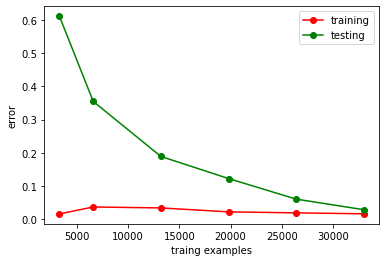

In [25]:
train_sizes,train_score,test_score = learning_curve(SVC(),features,labels,train_sizes=[0.1,0.2,0.4,0.6,0.8,1],cv=5,scoring='accuracy')
train_error =  1- np.mean(train_score,axis=1)
test_error = 1- np.mean(test_score,axis=1)
plt.plot(train_sizes,train_error,'o-',color = 'r',label = 'training')
plt.plot(train_sizes,test_error,'o-',color = 'g',label = 'testing')
plt.legend(loc='best')
plt.xlabel('traing examples')
plt.ylabel('error')
plt.show()